# ML Challenge 6 Part 1

Here is my attempt at the JLab A.I. Lunch series quarterly challenge issued Augus, 2020. Details on the challenge can be found here:

https://halldweb.jlab.org/talks/ML_lunch/Aug2020/

This challenge is to identify up to 2 pulses (amplitude and time) is a 128 sample waveform taken from calorimeter data. There are 190k wave forms and each may contain 0,1, or 2 pulses. The labels given represent the amplitudes and times of the pulses with special values of amplitude=0 and time=-1 to indicate no pulse.

The first step, as I have learned from the lunch series, is to always take a look at the data. i.e. *Know your data*.

In [1]:
# Read the full data file into a dataframe
# This file does not have a header so we define the column names here explicitly

import pandas as pd
import numpy as np

TRAIN_FILE  = '/home/davidl/work2/2020.08.12.ML_challenge6/Aug_2020_ML_train.csv'

# Columns in input file. First 5 are labels
names = ['ped', 'A1', 'A2', 't1', 't2']

# Next 128 are features (waveform)
for i in range(0,128): names.append('s%03d' % i)

# Read file and print how many waveforms are found
df = pd.read_csv(TRAIN_FILE, names=names)
print('Number of waveforms: %d' % len(df.index))


Number of waveforms: 190071


## Plot values

In the next cell I plot the values of each of the 5 labels. First, plotting all values and allowing the histogram to automatically select the x-axis range. This is not all that useful other than seeing what the range and values are for each parameter. Below that, I make the same plots, but cut out amplitudes that are zero, pedestals less than -200, and times less than zero. I also limit the x-axis ranges to something that shows me most of the data. This gives me a much better view of the distribution of the majority of the data.

At the end of the cell, I print some statistics on what is in the file regarding number of pulses. (The printed lines actually show up above the plots). With this I can see that only about 1/3 of the wave forms have any identified pulses. About 1/3 have exactly 1 pulse while only about 0.5% have two pulses. I can also see that when there is only one pulse, A1,t1 are set (i.e. there are no 1 pulse waveforms where A2,t2 are set).

                   Num. total: 190071
             Num. zero pulses: 126000
           Num. with A1 pulse: 64071
           Num. with A2 pulse: 1071
Num. with A1 but not A2 pulse: 63000
Num. with A2 but not A1 pulse: 0


,ped,A1,A2,t1,t2,s000,s001,s002,s003,s004,...,s118,s119,s120,s121,s122,s123,s124,s125,s126,s127
0,2.132430,263.75,0.0,38.0609,-1.0,0,5,0,11,7,...,-4,0,2,2,-5,0,-2,-2,-1,12
1,-0.557870,0.00,0.0,-1.0000,-1.0,0,-2,6,1,1,...,4,0,5,5,3,2,9,0,-4,4
2,1.114880,0.00,0.0,-1.0000,-1.0,-1,0,4,0,4,...,3,2,3,2,-8,2,1,0,-1,6
3,-0.257242,0.00,0.0,-1.0000,-1.0,4,5,8,8,2,...,0,0,5,9,10,5,-8,6,6,0
4,3.955660,284.46,0.0,37.3384,-1.0,8,12,5,-1,-5,...,-3,1,-4,8,4,3,10,4,-10,0


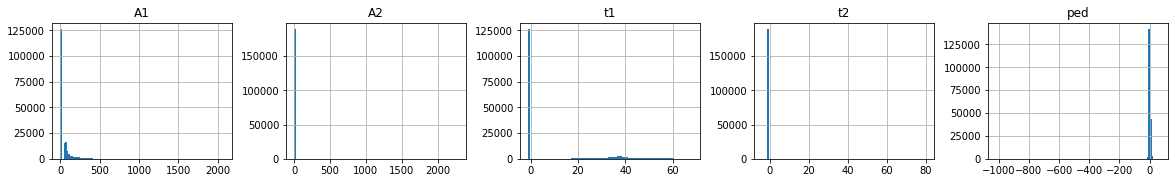

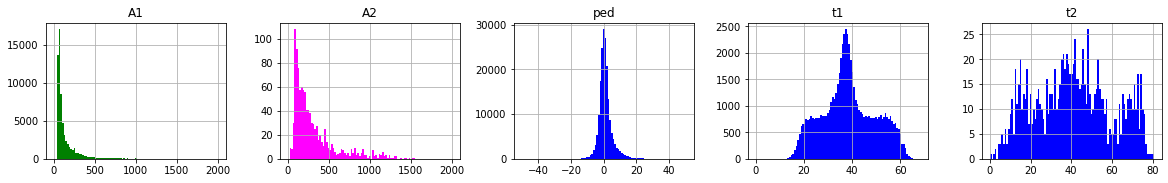

In [6]:
import matplotlib.pyplot as plt

# Plot all labels with default axes and no cuts
h = df.hist(column=['A1','A2','t1','t2','ped'], bins=100, figsize=(20.0,2.5), layout=(1,5))

# Plot with zeros suppressed
fig, ax = plt.subplots(1,5, figsize=(20,2.5))

dfA1 = df[df.A1 != 0]
dfA1.hist(ax=ax[0], column=['A1'], bins=np.linspace(0.0, 2000.0, 100), color='green')

dfA2 = df[df.A2 != 0]
dfA2.hist(ax=ax[1], column=['A2'], bins=np.linspace(0.0, 2000.0, 100), color='magenta')

dfped = df[df.ped >= -200]
dfped.hist(ax=ax[2], column=['ped'], bins=np.linspace(-50.0, 50.0, 100), color='blue')

dft1 = df[df.t1 >= 0]
dft1.hist(ax=ax[3], column=['t1'], bins=np.linspace(0.0, 68.0, 100), color='blue')

dft2 = df[df.t2 >= 0]
dft2.hist(ax=ax[4], column=['t2'], bins=np.linspace(0.0, 80.5, 100), color='blue')

dfno_pulses = df[(df.A1==0) & (df.A2==0)]
dfA1_not_A2 = df[(df.A1!=0) & (df.A2==0)]
dfA2_not_A1 = df[(df.A1==0) & (df.A2!=0)]

Ntot = len(df)
NA1  = len(dfA1)
NA2  = len(dfA2)
Nnone= len(dfno_pulses)
NA1_not_A2 = len(dfA1_not_A2)
NA2_not_A1 = len(dfA2_not_A1)

print('                   Num. total: %d' % Ntot)
print('             Num. zero pulses: %d' % Nnone)
print('           Num. with A1 pulse: %d' % NA1)
print('           Num. with A2 pulse: %d' % NA2)
print('Num. with A1 but not A2 pulse: %d' % NA1_not_A2)
print('Num. with A2 but not A1 pulse: %d' % NA2_not_A1)

df.head()

## Define model

In the next cell I define the model to fit to the data. Note that this does not actually create the model. It just defines the routines that get called in another cell further down. 

I break this up into *DefineModel*, *DefineCommonModel*, and *DefineCommonOutput* routines. This structure was inherited from a more complicated model I was working on, but I keep it since I find it makes it a little more readable and manageable. It also gives me flexibility if I want to increase the complexity of the model later.

One thing to note is that in *DefineModel* I compile the model to use a custom loss function. The *customLoss* function itself is defined in another cell further down. See the comments there for details on why I do this.

In [3]:
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Reshape, Flatten, Input, Lambda
from tensorflow.keras.optimizers import SGD, Adamax, Adadelta
from tensorflow.keras.callbacks import Callback, TensorBoard
import tensorflow.keras.backend as K
import tensorflow.keras.losses
import tensorflow as tf

GPUS    = 0
NINPUTS = 128
Nouts   = 200

#-----------------------------------------------------
# DefineModel
#-----------------------------------------------------
# This is used to define the model. It is only called if no model
# file is found in the model_checkpoints directory.
def DefineModel():

    # If GPUS==0 this will force use of CPU, even if GPUs are present
    # If GPUS>1 this will force the CPU to serve as orchestrator
    # If GPUS==1 this will do nothing, allowing GPU to act as its own orchestrator
    if GPUS!=1: tf.device('/cpu:0')

    # Here we build the network model.
    # This model is made of multiple parts. The first handles the
    # inputs and identifies common features. The rest are branches with
    # each determining an output parameter from those features.
    inputs         = Input(shape=(NINPUTS,), name='waveform')
    commonmodel    = DefineCommonModel(inputs)
    commonoutput   = DefineCommonOutput(commonmodel)

    model          = Model(inputs=inputs, outputs=commonoutput)

    # Compile the model, possibly using multiple GPUs
    opt = Adadelta(clipnorm=1.0)
    if GPUS<=1 :
        final_model = model
    else:
        final_model = multi_gpu_model( model, gpus=GPUS )

    #final_model.add_loss(customLoss( input_true, commonoutput, input_incov ) )
    final_model.compile(loss=customLoss, optimizer=opt, metrics=['mae', 'mse', 'accuracy'])
    
    return final_model

#-----------------------------------------------------
# DefineCommonModel
#-----------------------------------------------------
def DefineCommonModel(inputs):
    x = Flatten(name='top_layer1')(inputs)
    x = Dense(int(Nouts*5), name='common_layer1', activation='linear', kernel_initializer="glorot_uniform")(x)
    x = Dense(int(Nouts), name='common_layer2', activation='tanh', kernel_initializer="glorot_uniform")(x)
    x = Dense(int(Nouts), name='common_layer3', activation='linear', kernel_initializer="glorot_uniform")(x)
    x = Dense(int(Nouts), name='common_layer4', activation='tanh', kernel_initializer="glorot_uniform")(x)
    x = Dense(int(Nouts), name='common_layer5', activation='linear', kernel_initializer="glorot_uniform")(x)
    return x

#-----------------------------------------------------
# DefineCommonOutput
#-----------------------------------------------------
def DefineCommonOutput(inputs):
    #x = tf.keras.layers.concatenate( inputs )
    x = Dense(Nouts, name='common_out1', activation='linear', kernel_initializer="glorot_uniform")(inputs)
    x = Dense(Nouts, name='common_out2', activation='tanh', kernel_initializer="glorot_uniform")(x)
    x = Dense(Nouts, name='common_out3', activation='relu', kernel_initializer="glorot_uniform")(x)
    x = Dense(5, name='outputs', activation='relu', kernel_initializer="glorot_uniform")(x)
    return x



## Custom Loss Function

In the cell below I define a custom loss function. The motivation here is that the nature of the outputs (amplitudes and times) differs. Thus, simply doing a mean squared error loss that mixes them may not be sufficient. Yes, I could apply weights in the form of $1/\sigma^{2}$ to normalize them which could work. At this point though, I'm thinking I may need to include something more complex due to the special values used to indicate "no pulse". Setting up to use a custom loss let's me come back and play with this once I get all of the rest of the mechanism set up.

In [4]:
#--------------------------------------------
# Define custom loss function 
#-----------------------------------------------------
def customLoss(y_true, y_pred):

    batch_size = tf.shape(y_pred)[0]  # n.b. y_pred.shape[0] will not work for some reason in tf1
    print('y_pred shape: ' + str(y_pred.shape) )  # y_pred shape is (batch, 5)
    print('y_true shape: ' + str(y_true.shape) )  # y_true shape is (batch, 5)
     
    # Difference between prediction and true
    y_diff = y_pred - y_true
    y_loss = y_diff*y_diff
    
    # n.b. use "batch_dot" and not "dot"!
    #y_dot = K.batch_dot(invcov, y_diff)           # y_dot shape is (batch,5,1)
    #y_dot = K.reshape(y_dot, (batch_size, 1, 5))  # y_dot shape is now (batch,1,5)
    #y_loss = K.batch_dot(y_dot, y_diff)           # y_loss shape is (batch,1,1)
    #y_loss = K.reshape(y_loss, (batch_size,))     # y_loss shape is now (batch)
    return y_loss

## Load or build the model

In this next cell I actually call the above routines to build the model. However, before I do I check if there is a model left over from a previous training session. I do this so I can continue training if an earlier session was interrupted or even if I decide I want to do more epochs than I orignially set it to do. If I want to start fresh, I just need to manually remove any models in the *checkpoints_dir*.



In [5]:
# Here we want to check if a model has been saved due to previous training.
# If so, then we read it in and continue training where it left off. Otherwise,
# we define the model and start fresh. 

import os

checkpoints_dir = '/home/davidl/work2/2020.08.12.ML_challenge6/model_checkpoints_part1'

# Look for most recent saved epoch
epoch_loaded = -1
if os.path.exists(checkpoints_dir):
    for f in os.listdir(checkpoints_dir):
        if f.startswith('model_epoch') and f.endswith('.h5'):
            e = int(f[11:-3])
            if e > epoch_loaded:
                epoch_loaded = e
                fname = checkpoints_dir+'/model_epoch%03d.h5' % epoch_loaded

if epoch_loaded > 0:
    # Load the model. Note that we have to explicitly give it the customLoss function
    # since it will otherwise give a ValueError complaining that it doesn't know
    # what customLoss is.
    print('Loading model: ' + fname)
    model = load_model( fname, custom_objects={'customLoss':customLoss} )
else:
    print('Unable to find saved model. Will start from scratch')
    model = DefineModel()
    epoch_loaded = 0

# Print summary of model
model.summary()

Loading model: /home/davidl/work2/2020.08.12.ML_challenge6/model_checkpoints_part1/model_epoch002.h5
Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
waveform (InputLayer)        [(None, 128)]             0         
_________________________________________________________________
top_layer1 (Flatten)         (None, 128)               0         
_________________________________________________________________
common_layer1 (Dense)        (None, 1000)              129000    
_________________________________________________________________
common_layer2 (Dense)        (None, 200)               200200    
_________________________________________________________________
common_layer3 (Dense)        (None, 200)               40200     
_________________________________________________________________
common_layer4 (Dense)        (None, 200)               40200     
___________________

## Fit the model

In the following cell I fit the model. I set up the *checkPointModel* class to save the model at the end of every epoch. 

The number of epochs and the batch size are set here. 

In [13]:
#-----------------------------------------------------
# class checkpointModel
#-----------------------------------------------------
# There is a bug in keras that causes an error when trying to save a model
# trained on multiple GPUs. The work around is to save the original model
# at the end of every epoch using a callback. See
#    https://github.com/keras-team/kersas/issues/8694
if not os.path.exists(checkpoints_dir): os.mkdir(checkpoints_dir)
class checkpointModel(Callback):
    def __init__(self, model):
        self.model_to_save = model
    def on_epoch_end(self, epoch, logs=None):
        myepoch = epoch_loaded + epoch +1
        fname = checkpoints_dir+'/model_epoch%03d.h5' % myepoch
        old_fname = checkpoints_dir+'/model_epoch%03d.h5' % (myepoch-1)
        if os.path.exists( old_fname ):
            print('removing old model: %s' % old_fname)
            os.remove( old_fname )
        print('saving model: %s' % fname)
        self.model_to_save.save(fname)
cbk = checkpointModel( model )

cbk.on_epoch_end(-1)

EPOCHS = 2  # (in addition to anything already done)
BS     = 100

if epoch_loaded>0 : EPOCHS += epoch_loaded

# Inputs features and labels are all contained in the same row of the input file.
# Create new dataframes here that slice off the appropriate columns for labels
# and features.
y_labels      = df.iloc[:, 0:5]   # Peel off only 5 labels
x_waveform    = df.iloc[:,5:133]  # Peel off 128 waveform samples
print('  y_labels shape: ' + str(y_labels.shape))
print('x_waveform shape: ' + str(x_waveform.shape))

# Fit the model
history = model.fit(
    x = x_waveform,
    y = y_labels,
    batch_size = BS,
    epochs=EPOCHS,
    callbacks=[cbk],
    validation_split=0.2,
    shuffle=True,
    initial_epoch = epoch_loaded,
    use_multiprocessing=False
)


saving model: /home/davidl/work2/2020.08.12.ML_challenge6/model_checkpoints_part1/model_epoch000.h5
  y_labels shape: (190071, 5)
x_waveform shape: (190071, 128)
Epoch 1/2
y_pred shape: (None, 5)
y_true shape: (None, 5)
y_pred shape: (None, 5)
y_true shape: (None, 5)
1516/1521 [============================>.] - ETA: 0s - loss: 3027.0913 - mae: 13.2684 - mse: 3027.0913 - accuracy: 0.5106y_pred shape: (None, 5)
y_true shape: (None, 5)
removing old model: /home/davidl/work2/2020.08.12.ML_challenge6/model_checkpoints_part1/model_epoch000.h5
saving model: /home/davidl/work2/2020.08.12.ML_challenge6/model_checkpoints_part1/model_epoch001.h5
1521/1521 [==============================] - 11s 7ms/step - loss: 3029.6106 - mae: 13.2702 - mse: 3029.6106 - accuracy: 0.5110 - val_loss: 2946.4744 - val_mae: 12.9829 - val_mse: 2946.4741 - val_accuracy: 0.6486
Epoch 2/2
1515/1521 [============================>.] - ETA: 0s - loss: 2810.3784 - mae: 12.8822 - mse: 2810.3784 - accuracy: 0.7497removing old m

# Make images of waveforms

Here I make PNG images of several waveforms. The first row is just the first 8 from the file. The second row of 8 comes from entries with only a single pulse identified. The 3rd row of 8 comes from entries with 2 pulses indentified.

The numbers in the input file look to represent pedestal subtracted negative pulses with the values themselves being negative when the signal is "above" pedestal. For these plots, I flipped it so that the pulses are displayed as positive and are shifted by 100 units. I also truncated the plots to be only 512 units above pedestal. This means any value in the file that is below -512 will be plotted at the top line in the images and any values above +100 in the file will be plotting at the bottom line of the image.

Originally, the images were made by just coloring the pixel at the value which was harded to look at since it was just a bunch of dots. The option was added to draw lines. For this, it means coloring a vertical column from the actual pixel value to 

In [7]:
from IPython.display import Image, HTML, display
import png
import os

# Generate one PNG image file for the specified entry and dataframe.
# The drawlines option can set whether to draw lines between points.
# The prefix value will be prepended on the outpout filenames.
def MakeImage(irow, drawlines=False, mydf=df, prefix='', dirname='.'):
    row = mydf.iloc[irow][5:].tolist()
    
    width  = 128
    height = 512+100
    img = []
    for y in range(height):
        r = [255]*width
        img.append(r)

    for icol in range(width):
        yval = (100-int(row[icol]))  # For positive pulses: height - (100-int(row[icol]))
        yval = min(height-1, max(0, yval))
        img[yval][icol] = 0
        
        # Optionally draw lines between the dots
        if drawlines:
            if icol>0 :
                ymid = (int)((yval + last_yval)/2)
                ylo = min(last_yval, ymid)
                yhi = max(last_yval, ymid)
                for ylin in range(ylo, yhi): img[ylin][icol-1] = 0
                ylo = min(ymid, yval)
                yhi = max(ymid, yval)
                for ylin in range(ylo, yhi): img[ylin][icol-1] = 0
            last_yval = yval
    fname = prefix+'waveform_%06d.png' % irow
    if dirname != '.':
        try:
            os.makedirs(dirname)
        except:
            pass  # assume excpetion is because it already exists
        fname = os.path.join(dirname, fname)
    with open(fname, 'wb') as f:    
        w = png.Writer(width, height, greyscale=True)
        w.write(f, img)
        #print('Wrote file: ' + fname)
    return fname

# Generate PNG files for several waveforms and then return an HTML string that displays
# them all on one row.
def MakeHTML(mydf=df, Nentries=8, offset=0, prefix='', dirname='.', drawlines=True):
    pngimages = [MakeImage(e+offset, drawlines=drawlines, mydf=mydf, prefix=prefix, dirname=dirname) for e in range(Nentries)]
    imgs_html = []
    for fname in pngimages:
        imgs_html.append("<img style='width: 128px; margin: 2px; border: 1px solid blue;' src='%s' />" % fname)

    html = "<table>"
    for a in imgs_html: html += '<td>' + a + '</td>'
    return html

# Create PNG files for the first 8 waveforms, then the first 8 with one
# identified pulse, then the first 8 with 2 identified pulses.
display( HTML(MakeHTML(df, prefix='all_', dirname='all')) )
display( HTML(MakeHTML(dfA1_not_A2, prefix='one_pulse_lines_', dirname='one_pulse')) )
display( HTML(MakeHTML(dfA2, prefix='two_pulse_', dirname='two_pulse')) )
mydf.head()

### For comparison, draw the first 8 single pulse waveforms without connecting lines

In [8]:
display( HTML(MakeHTML(dfA1_not_A2, prefix='one_pulse_dots_', dirname='one_pulse_dots', drawlines=False)) )

### Generate image sets

Here I generate PNG files for each of the two and one pulse images. To avoid placing 60k files in the same directory for the one pulse waveforms, I break it up into ~60 directories with 1k files each. I also want to write image sets with lines and with dots. Thus, I define a routine to do this that takes the few parameters that need to be specified for each image set. Note that I generate a labels file in the top_dir of each image set that contains relative filenames and a custom set of labels. This is so I could drop the A2,t2 labels from the one pulse images. Thinking about it some more though, it probably makes sense just to keep the labels in the same format for all sets so I can more easily do tests later with a model generated from one applied to the other. Oh well, I'll leave the routine definition as it is and just pass in the same labels when I call it.

In [39]:
# Write a set of images using the specified dataframe and other parameters
def WriteImageSet(mydf, top_dir, col_names, drawlines):
    Ntotal = len(mydf)
    N_per_directory = 1000
    Ndirs = int(Ntotal/N_per_directory)+1

    # Open labels file
    f = open(top_dir+'/labels.csv', 'w')
    f.write('filename,%s\n' % ','.join(col_names))

    # Generate PNG image files 
    N = 0
    for i in range(Ndirs):
        dirname = top_dir + '/%02d' % i
        istart = i*N_per_directory
        if istart >= Ntotal: break
        iend = istart + N_per_directory
        if iend >= Ntotal: iend = Ntotal
        for j in range(istart, iend):
            fname = MakeImage(j, drawlines=drawlines, mydf=mydf, prefix='two_pulse_', dirname=dirname)
            fname = fname.split(top_dir+'/')[1] # drop top_dir part of path and just write relative path
            row = mydf.iloc[j]
            v = [row[col] for col in col_names]     # list of values in order of col_names
            valstr = ','.join([str(a) for a in v])  # make comma separated list of labels in order of col_names
            f.write('%s,%s\n' % (fname, valstr) )
            N = N+1

    # Close labels file
    f.close()
    
    print('Wrote %d images to %s' % (N, top_dir))

In [40]:
# Two pulse - lines
mydf = dfA2
top_dir = '/work/halld2/home/davidl/2020.08.12.ML_challenge6/PNG/two_pulse_lines'
col_names = ['ped','A1','t1','A2','t2']
drawlines = True
WriteImageSet(mydf, top_dir, col_names, drawlines)

Wrote 1071 images to /work/halld2/home/davidl/2020.08.12.ML_challenge6/PNG/two_pulse_lines


In [41]:
# Two pulse - dots
mydf = dfA2
top_dir = '/work/halld2/home/davidl/2020.08.12.ML_challenge6/PNG/two_pulse_dots'
col_names = ['ped','A1','t1','A2','t2']
drawlines = False
WriteImageSet(mydf, top_dir, col_names, drawlines)

Wrote 1071 images to /work/halld2/home/davidl/2020.08.12.ML_challenge6/PNG/two_pulse_dots


In [37]:
# One pulse - lines
mydf = dfA1_not_A2
top_dir = '/work/halld2/home/davidl/2020.08.12.ML_challenge6/PNG/one_pulse_lines'
col_names = ['ped','A1','t1','A2','t2']
drawlines = True
WriteImageSet(mydf, top_dir, col_names, drawlines)

Wrote 63000 images to /work/halld2/home/davidl/2020.08.12.ML_challenge6/PNG/one_pulse_lines


In [38]:
# One pulse - dots
mydf = dfA1_not_A2
top_dir = '/work/halld2/home/davidl/2020.08.12.ML_challenge6/PNG/one_pulse_dots'
col_names = ['ped','A1','t1','A2','t2']
drawlines = False
WriteImageSet(mydf, top_dir, col_names, drawlines)

Wrote 63000 images to /work/halld2/home/davidl/2020.08.12.ML_challenge6/PNG/one_pulse_dots
